In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/data/aruco

In [ ]:
!curl -L "https://universe.roboflow.com/ds/xqpmM4ZjHb?key=wxRu5GIYlo" > /content/data/aruco/roboflow.zip
!unzip /content/data/aruco/roboflow.zip -d /content/data/aruco/
!rm /content/data/aruco/roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   2123      0 --:--:-- --:--:-- --:--:--  2125
100  156M  100  156M    0     0  12.6M      0  0:00:12  0:00:12 --:--:-- 17.2M
Archive:  /content/data/aruco/roboflow.zip
 extracting: /content/data/aruco/README.dataset.txt  
 extracting: /content/data/aruco/README.roboflow.txt  
   creating: /content/data/aruco/train/
 extracting: /content/data/aruco/train/20230222_111633_jpg.rf.1af0cc56677eec0a0e80c3930a74e2cc.jpg  
 extracting: /content/data/aruco/train/20230222_111633_jpg.rf.d23060c06fb57bf521c3cb4335be9ee8.jpg  
 extracting: /content/data/aruco/train/20230222_111633_jpg.rf.e412049e56cee724bac51a8644d0a593.jpg  
 extracting: /content/data/aruco/train/20230222_111636_jpg.rf.06e7cd1e477376923b2f5aed49d2d16b.jpg  
 extracting: /content/data/aruco/train/20230222_111636_jpg.rf.440f079d5ed25582f3f2022109

In [ ]:
!ls /content/data/aruco/

README.dataset.txt  README.roboflow.txt  train	valid


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import json
from pycocotools.coco import COCO
import os
# Define the MobileViTv2 class
import argparse
from torch import nn
from typing import Dict, Tuple, Optional
from BaseLayers import InvertedResidual, GlobalPool
from mobilevit_v2_block import MobileViTBlockv2 as Block
from model_utils import bound_fn, make_divisible

In [ ]:
class MobileViTv2(nn.Module):
    def __init__(self, num_classes, *args, **kwargs) -> None:
        num_classes = num_classes
        pool_type = "mean"
        self.dilation = 1
        self.dilate_l4 = False
        self.dilate_l5 = False
        width_multiplier = 1.0
        ffn_multiplier = 2
        mv2_exp_mult = 2
        layer_0_dim = bound_fn(min_val=16, max_val=64, value=32 * width_multiplier)
        layer_0_dim = int(make_divisible(layer_0_dim, divisor=8, min_value=16))

        mobilevit_config = {
            "layer0": {"img_channels": 3, "out_channels": layer_0_dim},
            "layer1": {"out_channels": int(make_divisible(64 * width_multiplier, divisor=16)),
                       "expand_ratio": mv2_exp_mult, "num_blocks": 1, "stride": 1, "block_type": "mv2"},
            "layer2": {"out_channels": int(make_divisible(128 * width_multiplier, divisor=8)),
                       "expand_ratio": mv2_exp_mult, "num_blocks": 2, "stride": 2, "block_type": "mv2"},
            "layer3": {"out_channels": int(make_divisible(256 * width_multiplier, divisor=8)),
                       "attn_unit_dim": int(make_divisible(128 * width_multiplier, divisor=8)),
                       "ffn_multiplier": ffn_multiplier, "attn_blocks": 2, "patch_h": 2, "patch_w": 2, "stride": 2,
                       "mv_expand_ratio": mv2_exp_mult, "block_type": "mobilevit"},
            "layer4": {"out_channels": int(make_divisible(384 * width_multiplier, divisor=8)),
                       "attn_unit_dim": int(make_divisible(192 * width_multiplier, divisor=8)),
                       "ffn_multiplier": ffn_multiplier, "attn_blocks": 4, "patch_h": 2, "patch_w": 2, "stride": 2,
                       "mv_expand_ratio": mv2_exp_mult, "block_type": "mobilevit"},
            "layer5": {"out_channels": int(make_divisible(512 * width_multiplier, divisor=8)),
                       "attn_unit_dim": int(make_divisible(256 * width_multiplier, divisor=8)),
                       "ffn_multiplier": ffn_multiplier, "attn_blocks": 3, "patch_h": 2, "patch_w": 2, "stride": 2,
                       "mv_expand_ratio": mv2_exp_mult, "block_type": "mobilevit"},
            "last_layer_exp_factor": 4,
        }

        image_channels = mobilevit_config["layer0"]["img_channels"]
        out_channels = mobilevit_config["layer0"]["out_channels"]

        super().__init__(*args, **kwargs)

        self.model_conf_dict = dict()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=out_channels), nn.LeakyReLU(negative_slope=0.1))

        self.model_conf_dict["conv1"] = {"in": image_channels, "out": out_channels}

        in_channels = out_channels
        self.layer_1, out_channels = self._make_layer(input_channel=in_channels, cfg=mobilevit_config["layer1"])
        self.model_conf_dict["layer1"] = {"in": in_channels, "out": out_channels}

        in_channels = out_channels
        self.layer_2, out_channels = self._make_layer(input_channel=in_channels, cfg=mobilevit_config["layer2"])
        self.model_conf_dict["layer2"] = {"in": in_channels, "out": out_channels}

        in_channels = out_channels
        self.layer_3, out_channels = self._make_layer(input_channel=in_channels, cfg=mobilevit_config["layer3"])
        self.model_conf_dict["layer3"] = {"in": in_channels, "out": out_channels}

        in_channels = out_channels
        self.layer_4, out_channels = self._make_layer(input_channel=in_channels, cfg=mobilevit_config["layer4"],
                                                      dilate=self.dilate_l4)
        self.model_conf_dict["layer4"] = {"in": in_channels, "out": out_channels}

        in_channels = out_channels
        self.layer_5, out_channels = self._make_layer(input_channel=in_channels, cfg=mobilevit_config["layer5"],
                                                      dilate=self.dilate_l5)
        self.model_conf_dict["layer5"] = {"in": in_channels, "out": out_channels}

        self.conv_1x1_exp = nn.Identity()
        self.model_conf_dict["exp_before_cls"] = {"in": out_channels, "out": out_channels}

        self.classifier = nn.Sequential(GlobalPool(pool_type=pool_type, keep_dim=False),
                                        nn.Linear(in_features=out_channels, out_features=num_classes, bias=True))

    def _make_layer(self, input_channel, cfg: Dict, dilate: Optional[bool] = False) -> Tuple[nn.Sequential, int]:
        block_type = cfg.get("block_type", "mobilevit")
        if block_type.lower() == "mobilevit":
            return self._make_mit_layer(input_channel=input_channel, cfg=cfg, dilate=dilate)
        else:
            return self._make_mobilenet_layer(input_channel=input_channel, cfg=cfg)

    def _make_mobilenet_layer(self, input_channel: int, cfg: Dict) -> Tuple[nn.Sequential, int]:
        output_channels = cfg.get("out_channels")
        num_blocks = cfg.get("num_blocks", 2)
        expand_ratio = cfg.get("expand_ratio", 4)
        block = []

        for i in range(num_blocks):
            stride = cfg.get("stride", 1) if i == 0 else 1
            layer = InvertedResidual(in_channels=input_channel, out_channels=output_channels, stride=stride,
                                     expand_ratio=expand_ratio)
            block.append(layer)
            input_channel = output_channels
        return nn.Sequential(*block), input_channel

    def _make_mit_layer(self, input_channel, cfg: Dict, dilate: Optional[bool] = False) -> Tuple[nn.Sequential, int]:
        prev_dilation = self.dilation
        block = []
        stride = cfg.get("stride", 1)

        if stride == 2:
            if dilate:
                self.dilation *= 2
                stride = 1
            layer = InvertedResidual(in_channels=input_channel, out_channels=cfg.get("out_channels"), stride=stride,
                                     expand_ratio=cfg.get("mv_expand_ratio", 4), dilation=prev_dilation)
            block.append(layer)
            input_channel = cfg.get("out_channels")

        attn_unit_dim = cfg["attn_unit_dim"]
        ffn_multiplier = cfg.get("ffn_multiplier")
        dropout = 0.0

        block.append(Block(in_channels=input_channel, attn_unit_dim=attn_unit_dim, ffn_multiplier=ffn_multiplier,
                           n_attn_blocks=cfg.get("attn_blocks", 1), patch_h=cfg.get("patch_h", 2),
                           patch_w=cfg.get("patch_w", 2), dropout=dropout, ffn_dropout=0.0, attn_dropout=0.0,
                           conv_ksize=3, dilation=self.dilation))

        return nn.Sequential(*block), input_channel

    def forward(self, x, *args, **kwargs):
        x = self.conv_1(x)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x = self.conv_1x1_exp(x)
        x = self.classifier(x)
        return x


In [ ]:
# COCO Dataset Loader
class COCODataset(Dataset):
    def __init__(self, annotation_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root_dir, path)).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        labels = [ann['category_id'] for ann in target]
        labels = torch.tensor(labels)
        return img, labels[0]  # Assuming one label per image for simplicity

    def __len__(self):
        return len(self.ids)

In [ ]:
# Set up the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Instantiate the COCO dataset
train_dataset = COCODataset(annotation_file='./data/aruco/train/_annotations.coco.json', root_dir='./data/aruco/train',
                            transform=transform)
test_dataset = COCODataset(annotation_file='./data/aruco/valid/_annotations.coco.json', root_dir='./data/aruco/valid',
                           transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Function to train the model
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

In [ ]:
# Function to evaluate the model
def evaluate(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            # Print some debugging information
            if total <= 20:  # Print the first 20 predictions
                print(f"Data: {data}")
                print(f"Target: {target}")
                print(f"Predicted: {predicted}")
    return correct / total



In [ ]:
import pickle
import matplotlib.pyplot as plt

In [ ]:
# # Main training function (with the necessary imports and adjustments)
# def main(args):
#     # Configuration and initialization as previously defined
#     histories = {}

#     model = MobileViTv2(num_classes=3)  # Adjust num_classes based on your specific dataset
#     # Check if GPU is available
#     global device
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)

#     criterion = nn.CrossEntropyLoss()
#     #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#     # Training loop
#     for epoch in range(args.epochs):  # Example for 10 epochs
#         train_loss = train(model, train_loader, criterion, optimizer)
#         test_acc = evaluate(model, test_loader, criterion)
#         print(f"Epoch {epoch + 1}/{args.epochs}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.4f}")

#     # Save the trained model
#     torch.save(model.state_dict(), f'/content/drive/MyDrive/PENELITIAN/S3/MobileVit_library/ArucoModels/mobilevit_v2.pth')
#     print('Training completed and model saved.')

In [ ]:
import argparse
import sys
import time
import numpy as np

In [ ]:
# if __name__ == "__main__":
#     parser = argparse.ArgumentParser(description="ArUco CNN Classifier")
#     parser.add_argument("--batch_size", type=int, default=64, help="input batch size for training (default: 64)")
#     parser.add_argument("--epochs", type=int, default=10, help="number of epochs to train (default: 10)")
#     parser.add_argument("--lr", type=float, default=0.01, help="learning rate (default: 0.01)")
#     #parser.add_argument("--momentum", type=float, default=0.9, help="SGD momentum (default: 0.9)")

#     # Simulate command-line arguments in a Jupyter/Colab environment
#     # Example: passing arguments directly
#     #simulated_args = ["--batch_size", "32", "--epochs", "10", "--lr", "0.001", "--momentum", "0.95"]
#     simulated_args = ["--batch_size", "32", "--epochs", "10", "--lr", "0.001"]
#     args = parser.parse_args(simulated_args)
#     main(args)


In [ ]:
# @title Default title text
# Configuration parameters
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, and optimizer
model = MobileViTv2(num_classes=3)  # Adjust num_classes based on your specific dataset
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
histories = {'loss': [], 'accuracy': [], 'epoch_time': []}
total_start_time = time.time()

for epoch in range(epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, criterion, optimizer)
    test_acc = evaluate(model, test_loader, criterion)

    end_time = time.time()
    epoch_time = end_time - start_time
    histories['epoch_time'].append(epoch_time)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.4f}, Time: {epoch_time:.2f} seconds")

    histories['loss'].append(train_loss)
    histories['accuracy'].append(test_acc)

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')

# Save the trained model
torch.save(model.state_dict(), '/content/mobilevit_v2.pth')
print('Training completed and model saved.')


Epoch 1/10, Train Loss: 0.3929, Test Accuracy: 1.0000, Time: 87.08 seconds
Epoch 2/10, Train Loss: 0.0002, Test Accuracy: 1.0000, Time: 83.69 seconds
Epoch 3/10, Train Loss: 0.0001, Test Accuracy: 1.0000, Time: 82.08 seconds
Epoch 4/10, Train Loss: 0.0001, Test Accuracy: 1.0000, Time: 81.71 seconds
Epoch 5/10, Train Loss: 0.0001, Test Accuracy: 1.0000, Time: 81.74 seconds
Epoch 6/10, Train Loss: 0.0001, Test Accuracy: 1.0000, Time: 82.00 seconds
Epoch 7/10, Train Loss: 0.0001, Test Accuracy: 1.0000, Time: 82.82 seconds
Epoch 8/10, Train Loss: 0.0001, Test Accuracy: 1.0000, Time: 81.89 seconds
Epoch 9/10, Train Loss: 0.0001, Test Accuracy: 1.0000, Time: 81.83 seconds
Epoch 10/10, Train Loss: 0.0001, Test Accuracy: 1.0000, Time: 81.84 seconds
Total Training Time: 826.68 seconds
Training completed and model saved.


In [ ]:
# Save the MobileViT training history
with open('/content/drive/MyDrive/PENELITIAN/S3/MobileVit_library/ArucoModels/mobilevit_history.pickle', 'wb') as file:
    pickle.dump(histories, file)

In [ ]:
# Path to the Keras training history pickle file
keras_history_path = '/content/drive/MyDrive/PENELITIAN/S3/MobileVit_library/ArucoModels/historykeras.pickle'

def load_keras_histories(filepath):
    with open(filepath, 'rb') as f:
        keras_histories = pickle.load(f)
    return keras_histories

keras_histories = load_keras_histories(keras_history_path)




In [ ]:
# Load the MobileViT history
mobilevit_history_path = '/content/drive/MyDrive/PENELITIAN/S3/MobileVit_library/ArucoModels/mobilevit_history_SGD_001.pickle'
with open(mobilevit_history_path, 'rb') as file:
    mobilevit_history = pickle.load(file)

In [ ]:
# Load and print the history structures to debug
print(mobilevit_history)
print(keras_histories)

{'loss': [0.9768430316448211, 0.6622687125205994, 0.44755314648151395, 0.30949554562568665, 0.22100151747465133, 0.1636404252052307, 0.1254772375524044, 0.09926921963691711, 0.08065398067235946, 0.06702373743057251], 'accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'epoch_time': [55.14207577705383, 56.85771083831787, 56.946343421936035, 57.30129909515381, 58.6810462474823, 59.15914607048035, 57.40613079071045, 57.43385410308838, 57.432735204696655, 58.07212233543396]}
{'ResNet50': <keras.src.callbacks.History object at 0x790558741930>, 'MobileNetV2': <keras.src.callbacks.History object at 0x7905587be7d0>, 'DenseNet121': <keras.src.callbacks.History object at 0x7905e03995d0>, 'VGG16': <keras.src.callbacks.History object at 0x790572ed7160>, 'InceptionV3': <keras.src.callbacks.History object at 0x79058411ae60>, 'NASNetMobile': <keras.src.callbacks.History object at 0x79057e785480>}


In [ ]:
def extract_keras_history(history):
    return {
        'loss': history.history.get('loss', []),
        'accuracy': history.history.get('accuracy', []),
        'precision': history.history.get('precision', []),
        'recall': history.history.get('recall', []),
        'f1_score': history.history.get('f1_score', [])
    }

# Extract data from Keras History objects
keras_histories_extracted = {name: extract_keras_history(history) for name, history in keras_histories.items()}

# Verify the extracted histories
print(keras_histories_extracted)


{'ResNet50': {'loss': [0.6666848063468933, 0.21899916231632233, 0.1466413140296936, 0.10286840796470642, 0.08739222586154938, 0.08211972564458847, 0.06300076842308044, 0.04931173846125603, 0.05701751261949539, 0.04876662790775299], 'accuracy': [0.7182825207710266, 0.9229916930198669, 0.9509695172309875, 0.9667590260505676, 0.9717451333999634, 0.9720221757888794, 0.9792243838310242, 0.9844875335693359, 0.9797784090042114, 0.9833794832229614], 'precision': [], 'recall': [], 'f1_score': []}, 'MobileNetV2': {'loss': [0.22530893981456757, 0.04382213577628136, 0.0428137369453907, 0.02972431480884552, 0.019956644624471664, 0.013908526860177517, 0.02337401732802391, 0.014871306717395782, 0.019764255732297897, 0.02057521790266037], 'accuracy': [0.9155124425888062, 0.9839335083961487, 0.9847645163536072, 0.9889196753501892, 0.9925207495689392, 0.9958449006080627, 0.9914127588272095, 0.9944598078727722, 0.9919667840003967, 0.9925207495689392], 'precision': [], 'recall': [], 'f1_score': []}, 'Dens

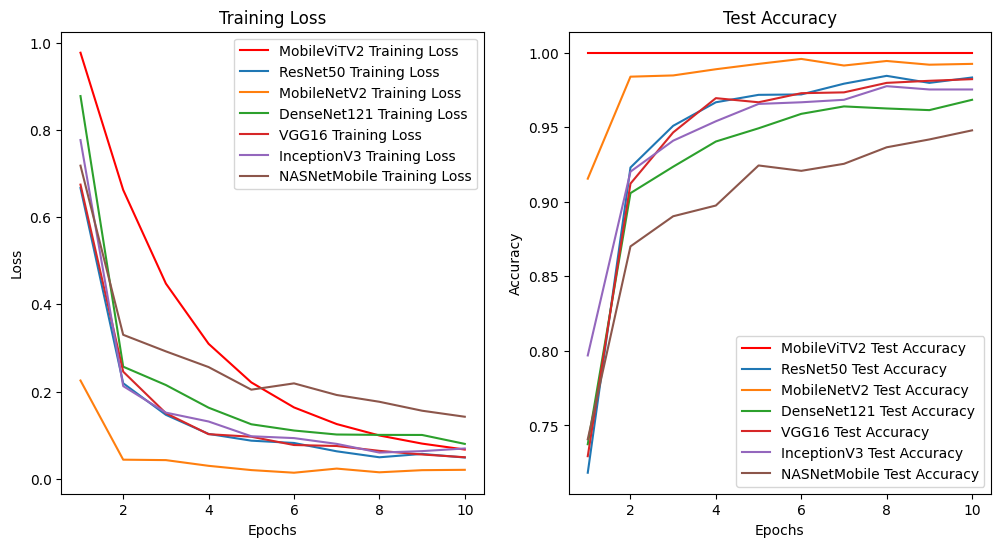

In [ ]:
def plot_combined_histories(mobilevit_history, keras_histories, epochs):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, mobilevit_history['loss'], 'r', label='MobileViTV2 Training Loss')
    for name, history in keras_histories.items():
        if 'loss' in history:
            plt.plot(epochs, history['loss'], label=f'{name} Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mobilevit_history['accuracy'], 'r', label='MobileViTV2 Test Accuracy')
    for name, history in keras_histories.items():
        if 'accuracy' in history:
            plt.plot(epochs, history['accuracy'], label=f'{name} Test Accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Extract the relevant data from Keras History objects
keras_histories_extracted = {name: extract_keras_history(history) for name, history in keras_histories.items()}

# Check if the epochs lengths match
epochs = range(1, min(len(mobilevit_history['loss']), *(len(history['loss']) for history in keras_histories_extracted.values())) + 1)

# Plot the results
plot_combined_histories(mobilevit_history, keras_histories_extracted, epochs)


## Convert TFLite

In [ ]:
import torch

# Muat model yang telah Anda latih
model = MobileViTv2(num_classes=3)
model.load_state_dict(torch.load('/content/mobilevit_v2.pth'))
model.eval()

# Tentukan input tensor yang sesuai
dummy_input = torch.randn(1, 3, 256, 256)

# Ekspor model ke ONNX
torch.onnx.export(model, dummy_input, "mobilevit_v2.onnx", opset_version=11, input_names=['input'], output_names=['output'])


<ipython-input-20-eb406a373793>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/mobilevit_v2.pth'))
/content/mobilevit_v2_block.p

In [3]:
import onnx
from onnx_tf.backend import prepare

# Load ONNX model
onnx_model = onnx.load("mobilevit_v2.onnx")

# Convert ONNX model to TensorFlow
tf_rep = prepare(onnx_model)

# Export the TensorFlow model to a directory
tf_rep.export_graph("mobilevit_v2_tf")


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
import tensorflow as tf

# Muat model TensorFlow
converter = tf.lite.TFLiteConverter.from_saved_model('mobilevit_v2_tf')
tflite_model = converter.convert()

# Simpan model dalam format TFLite
with open('mobilevit_v2.tflite', 'wb') as f:
    f.write(tflite_model)


In [4]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()

with open('mobilevit_v2_quant.tflite', 'wb') as f:
    f.write(tflite_model_quant)
